In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
import plotly.figure_factory as ff

from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

# Bring out dataset
dataset = pd.read_csv('training.csv')

# Fill missing values
dataset.fillna(dataset.describe().T['50%'], inplace=True)
dataset.sample(5).T

,4864,1976,386,3753,4304
left_eye_center_x,65.633185,66.971695,65.023256,65.514833,65.232835
left_eye_center_y,35.244764,37.637223,39.856372,40.647704,38.024821
right_eye_center_x,30.373061,24.858141,29.104372,33.562856,30.606887
right_eye_center_y,41.121434,36.987226,35.865302,39.932361,44.501635
left_eye_inner_corner_x,59.304615,56.821421,59.036279,59.304615,59.304615
left_eye_inner_corner_y,37.878040,39.275719,40.189023,37.878040,37.878040
left_eye_outer_corner_x,73.247824,77.258811,71.342140,73.247824,73.247824
left_eye_outer_corner_y,37.639015,38.903606,41.186977,37.639015,37.639015
right_eye_inner_corner_x,36.651562,34.765941,35.423256,36.651562,36.651562
right_eye_inner_corner_y,37.944075,39.143679,37.528558,37.944075,37.944075


In [15]:
def sort_pattern(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def load_images(path):
    images = []
    file_list = os.listdir(path)
    sorted_file = sorted(file_list, key=sort_pattern)

    for filename in sorted_file:
        if filename.endswith(".jpg"):
            img_path = os.path.join(path, filename)
            img = Image.open(img_path).convert('L')
            images.append(np.array(img))  # Convert PIL Image to NumPy array
            img.close()

    return images

def show_keypoints(images, keypoints, n_rows=3, n_cols=7):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), dpi=100)

    for i, ax in enumerate(axes.flatten()):
        img_array = np.array(images[i], dtype=np.uint8)  # Convert list of images to NumPy array
        img_array = img_array.squeeze()  # Remove singleton dimensions
        img = Image.fromarray(img_array)  # Convert NumPy array to PIL Image
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Sample #{i}')

        for j in range(0, len(keypoints[i]), 2):
            x = keypoints[i][j]
            y = keypoints[i][j + 1]
            ax.plot(x, y, 'ro', markersize=2)

    plt.tight_layout()
    plt.show()

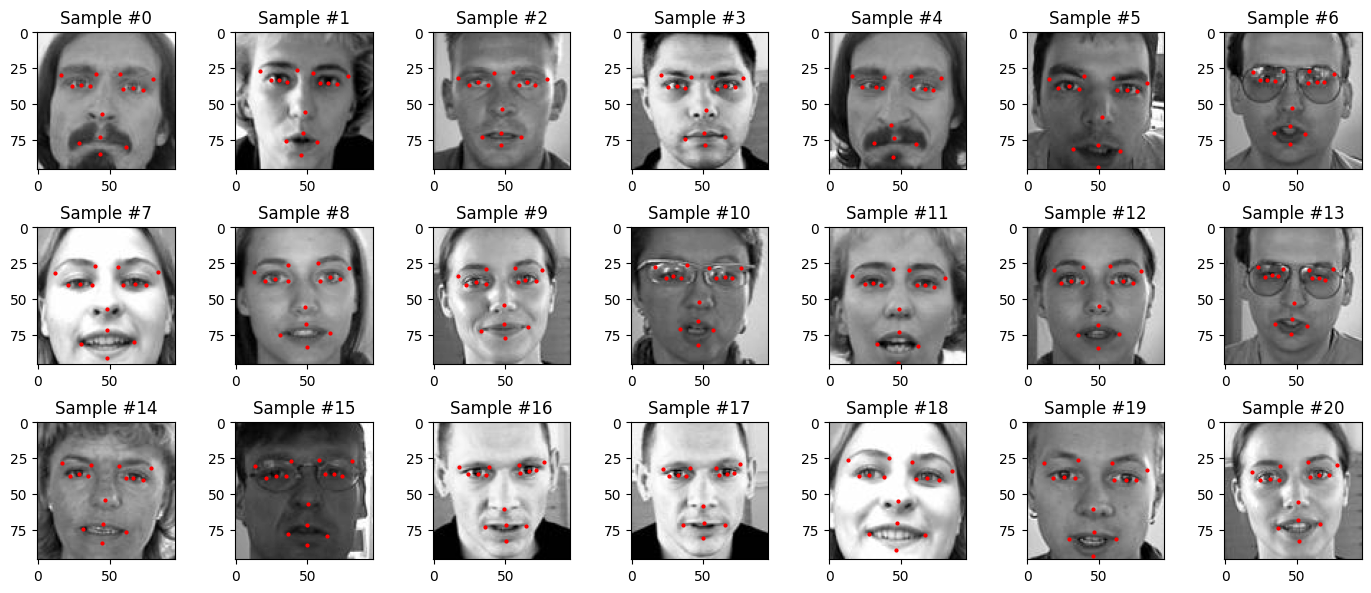

In [13]:
# Collect the images into an array of order
path = r"images"
images = load_images(path)

# Split the training and testing data
images = np.array(images).reshape(-1, 96, 96, 1).astype('float64')
data = dataset.values.astype('float64')
x_train, x_test, y_train, y_test = train_test_split(images, data, test_size=0.2, shuffle=False, random_state=42)

# Show some examples
show_keypoints(x_train[:21], y_train[:21])

In [16]:
# With ResNet we don't have to worry about the vanishing gradient
# See more about skip connections
# Define the rest of your model
resnet_model = tf.keras.models.Sequential()

# Add a Conv2D layer to match the input shape of the pre-trained ResNet50
resnet_model.add(Conv2D(3, (1, 1), padding='same', input_shape=(96, 96, 1)))
resnet_model.add(LeakyReLU(alpha=0.1))

# Add the pre-trained ResNet50 model with weights from ImageNet
pretrained_model = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True
resnet_model.add(pretrained_model)

# Add a GlobalAveragePooling2D layer to reduce spatial dimensions
resnet_model.add(GlobalAveragePooling2D())

# Add a Dropout layer to prevent overfitting
resnet_model.add(Dropout(0.1))

# Add a Dense layer with 30 output nodes for facial keypoints
resnet_model.add(Dense(30))

# Display the model summary
resnet_model.summary()

# Early stopping to prevent overfitting
# Monitors training loss
early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min', baseline=None)

# Reduce learning rate for improving convergence
# Dynamically adjust learning rate
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)
resnet_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 30)                61

In [17]:
history = resnet_model.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping, reduce_LR], batch_size=32)
print(history.history)

Epoch 1/100
141/141 [==============================] - 59s 114ms/step - loss: 166.5625 - mae: 5.7588 - acc: 0.5043 - val_loss: 57.7474 - val_mae: 6.9800 - val_acc: 0.2358 - lr: 0.0010
Epoch 2/100
141/141 [==============================] - 13s 94ms/step - loss: 8.0204 - mae: 1.8506 - acc: 0.6970 - val_loss: 164.6009 - val_mae: 11.9382 - val_acc: 0.8138 - lr: 0.0010
Epoch 3/100
141/141 [==============================] - 15s 107ms/step - loss: 6.2856 - mae: 1.6743 - acc: 0.7417 - val_loss: 121.9796 - val_mae: 9.9002 - val_acc: 0.7846 - lr: 0.0010
Epoch 4/100
141/141 [==============================] - 13s 95ms/step - loss: 5.0963 - mae: 1.5245 - acc: 0.7632 - val_loss: 90.8179 - val_mae: 8.6143 - val_acc: 0.7970 - lr: 0.0010
Epoch 5/100
141/141 [==============================] - 13s 93ms/step - loss: 4.6499 - mae: 1.4442 - acc: 0.7814 - val_loss: 51.9589 - val_mae: 6.2641 - val_acc: 0.7855 - lr: 0.0010
Epoch 6/100
141/141 [==============================] - 13s 93ms/step - loss: 3.9922 - ma

In [18]:
import pickle

resnet_model.save("NewResNet50.h5")
with open('NewResNet50.pkl', 'wb') as f:
    pickle.dump(history.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss', 'mae', 'acc', 'val_loss', 'val_mae', 'val_acc', 'lr'])


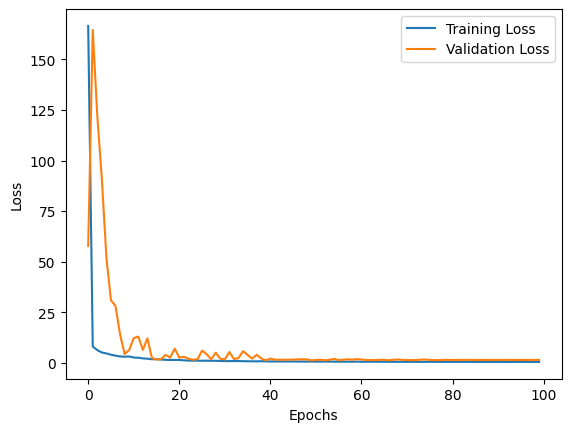

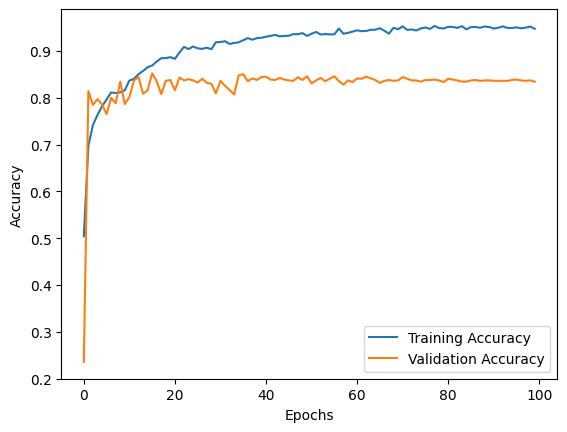

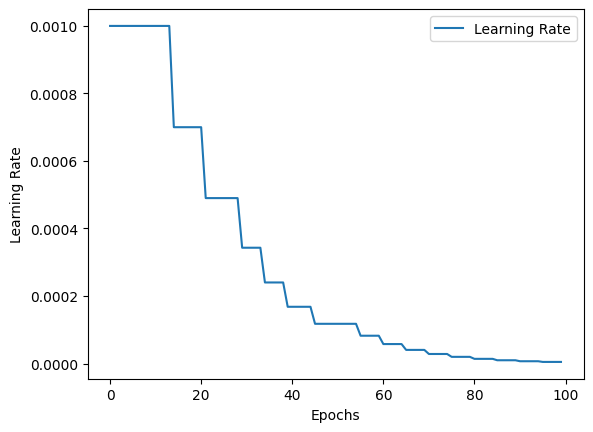

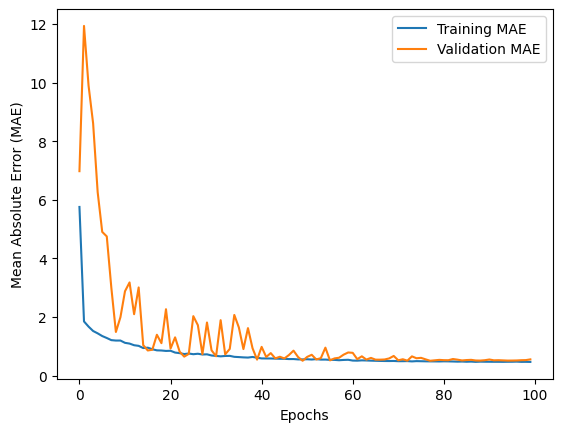

In [19]:
print(history.history.keys())

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot learning rate
plt.plot(history.history['lr'], label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

# Plot mean squared error
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

45/45 [==============================] - 1s 25ms/step


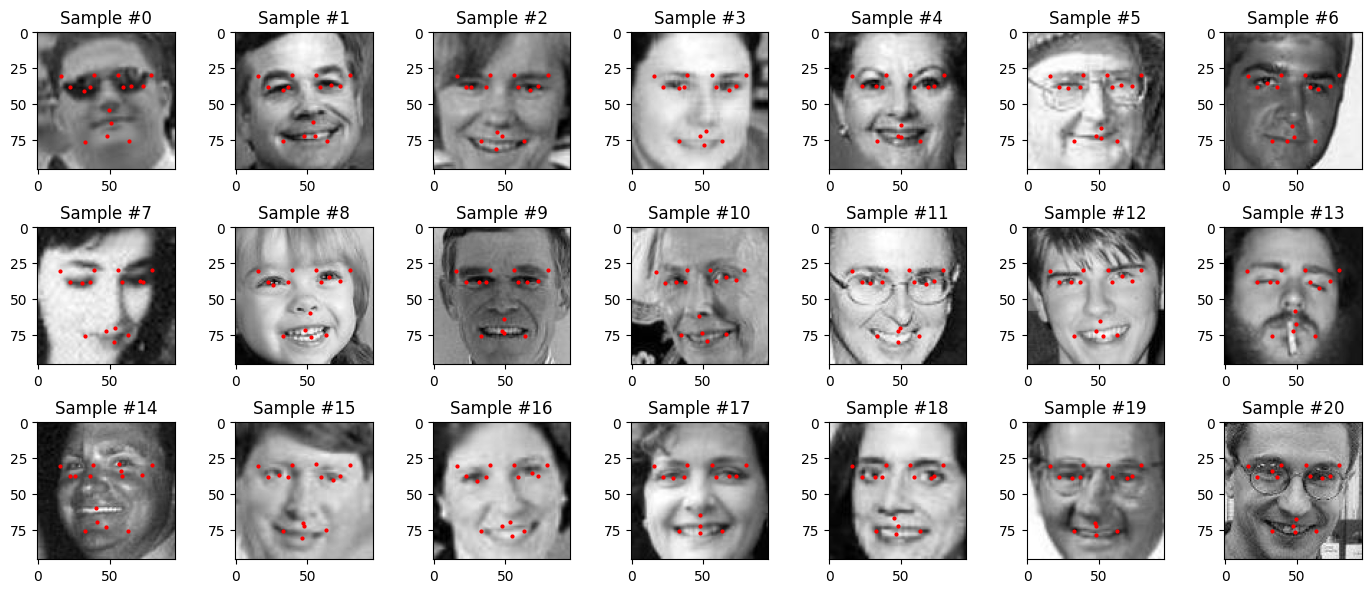

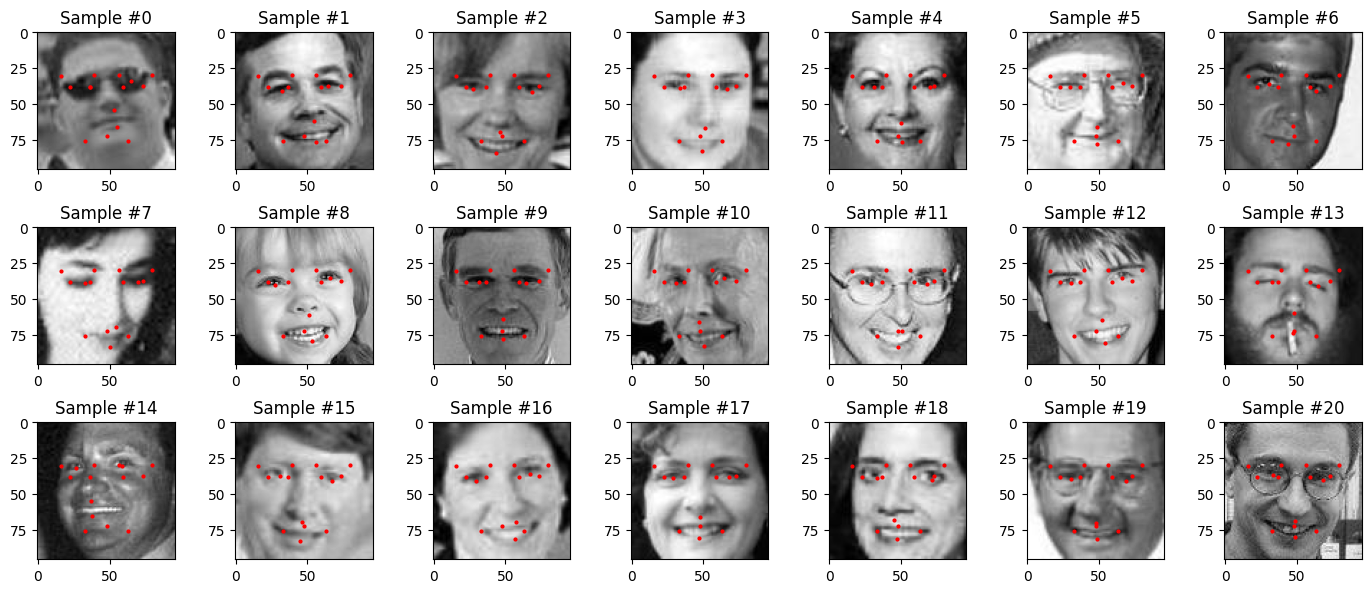

In [35]:
# Make a prediction by looking at x_test images
y_pred = resnet_model.predict(x_test)

# Predicted points on the images
show_keypoints(x_test[:21], y_pred[:21])

# Actual data points on the images
show_keypoints(x_test[:21], y_test[:21])

Mean Squared Error: 1.8705902868068947
Actual length: 1410
Predicted length: 1410


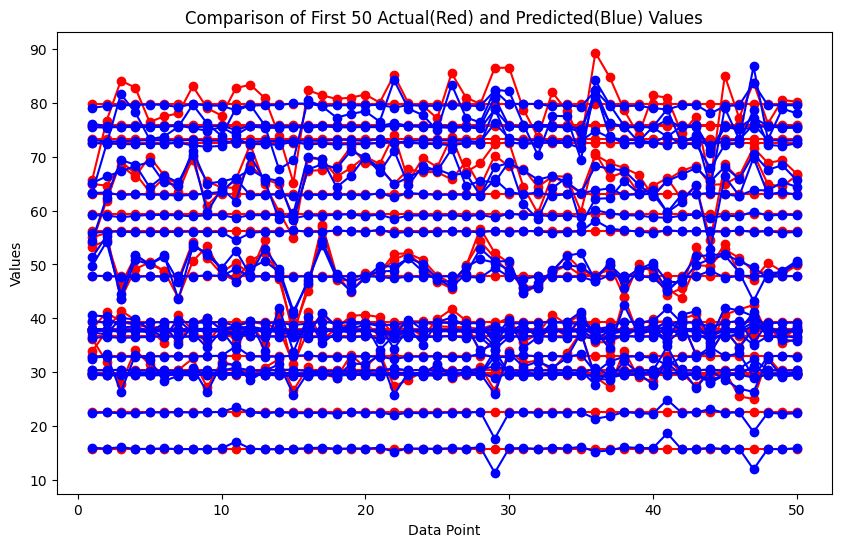

In [34]:
y_actual = np.array(y_test)
y_prediction = np.array(y_pred)
differences = y_actual - y_prediction
squared_differences = differences ** 2
mse = np.mean(squared_differences)
print("Mean Squared Error:", mse)


print("Actual length:", len(y_actual))
print("Predicted length:", len(y_prediction))

plt.figure(figsize=(10, 6))

plt.plot(range(1, 51), y_actual[:50], 'ro-', label='Actual')
plt.plot(range(1, 51), y_prediction[:50], 'bo-', label='Predicted')

# Customize the plot
plt.title('Comparison of First 50 Actual(Red) and Predicted(Blue) Values')
plt.xlabel('Data Point')
plt.ylabel('Values')

# Show the plot
plt.show()